In [1]:
import torch
factor = 8
linear_dim = 90112
linear_dim2 = int( linear_dim/ factor) 
linear_dim3 = int(linear_dim/ (factor*factor))
linear_dim4 = int(linear_dim/ (factor*factor*factor))

class Encoder(torch.nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = torch.nn.Sequential(
                torch.nn.Conv2d(1, 512, (3,3), stride=2,padding=1 ),
                torch.nn.LayerNorm(512),
                torch.nn.GELU(),
                torch.nn.Conv2d(512, 256, (3,3), stride=2,padding=1 ),
                torch.nn.LayerNorm(256),
                torch.nn.GELU(),
                torch.nn.Conv2d(256, 128, (3,3), stride=2,padding=1 ),
                torch.nn.LayerNorm(128),
                torch.nn.GELU(),
                torch.nn.Conv2d(128, 32, (3,3), stride=2,padding=1 ),
                torch.nn.LayerNorm(64),
                torch.nn.GELU(),    
                torch.nn.Flatten()  
            )
     

        self.dense_encoder = torch.nn.Sequential(
            torch.nn.Linear(linear_dim, linear_dim2 ),
            torch.nn.LeakyReLU(),
        )
        self.mu_fc = torch.nn.Linear(linear_dim2, linear_dim3)
        self.sigma_fc = torch.nn.Linear(linear_dim2, linear_dim3)
        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.to("cuda:0")
        self.N.scale = self.N.scale.to("cuda:0")
        self.kl = 0

    def forward(self, x):
        coded = self.encoder(x)
        latent = self.dense_encoder(coded)
        mu = self.mu_fc(latent)
        # print("MUUUU", mu)
        sigma = torch.exp(self.sigma_fc(latent))
        # print("SIGMA", sigma)

        z = z = self.reparameterize(mu, sigma)
        self.kl = torch.mean(-0.2 * torch.sum(1 + sigma - mu ** 2 - sigma.exp(), dim = 1), dim = 0)
        # print("KLLLLL", self.kl)
        return z
        return latent

    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu
    
class Decoder(torch.nn.Module): 
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.dense_decoder = torch.nn.Sequential(
            torch.nn.Linear(linear_dim3, linear_dim2),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(linear_dim2, linear_dim ),
            torch.nn.LeakyReLU(),
        )

        self.decoder = torch.nn.Sequential(
                torch.nn.Unflatten(1, (32,44,64)),
                torch.nn.ConvTranspose2d(32, 128, (3,3), stride=2, padding=1, output_padding=1),
                torch.nn.LayerNorm(128),
                torch.nn.GELU(),
                torch.nn.ConvTranspose2d(128, 256, (3,3), stride=2, padding=1, output_padding=1),
                torch.nn.LayerNorm(256),
                torch.nn.GELU(),
                torch.nn.ConvTranspose2d(256, 512, (3,3), stride=2, padding=1, output_padding=1),
                torch.nn.LayerNorm(512),
                torch.nn.GELU(),
                torch.nn.ConvTranspose2d(512, 768, (3,3), stride=2, padding=1, output_padding=1),
                torch.nn.LayerNorm(1024),
                torch.nn.GELU(), 
                torch.nn.ConvTranspose2d(768, 1, (1,1), stride=1, ),
                torch.nn.LayerNorm(1024),
                torch.nn.GELU(),    
            )
        
    def forward(self,x):
        decoded_laten = self.dense_decoder(x)
        decoded = self.decoder(decoded_laten)
        return decoded


In [2]:
class AutoEncoder(torch.nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
        self.encoder = Encoder().to("cuda:0")
        self.decoder = Decoder().to("cuda:1")

    
    def forward(self, x):
        x.to("cuda:0")
        encoded = self.encoder(x)
        bro = encoded.to("cuda:1")
        
        decoded = self.decoder(bro)
        return decoded

In [3]:

from torch import nn as nn
from typing import Callable

def execute_epoch(
    model: nn.Module,
    criterion: nn.modules.loss._Loss,
    dataloader: torch.utils.data.DataLoader,
    prepare_inputs: Callable[[torch.Tensor], torch.Tensor] = lambda x: x,
    prepare_labels: Callable[[torch.Tensor], torch.Tensor] = lambda x: x,
    on_batch_done: Callable[
        [int, torch.Tensor, float, float], None
    ] = lambda idx, outputs, loss, running_mad: None,
    optimizer: torch.optim.Optimizer = None,
):
    losses = []
    running_loss = 0.0
    epoch_mad = 0.0
    # Iterate over data.
    for idx, inputs  in enumerate(dataloader):
        inputs = prepare_inputs(inputs)
        # zero the parameter gradients
        if optimizer:
            optimizer.zero_grad()
        outputs = model(inputs.to("cuda:0"))
        loss = criterion(outputs, inputs.to("cuda:1"))
        loss += model.encoder.kl.to("cuda:1")
        
        losses.append(loss.item())

        # statistics
        batch_loss = loss.item()

        running_loss += batch_loss
       
        running_mad = epoch_mad / (idx + 1)
        on_batch_done(idx, outputs, loss, running_mad)

    epoch_mad = epoch_mad / len(dataloader)
    epoch_loss = running_loss / len(dataloader)
    return (
        epoch_loss,
        epoch_mad,
    )

In [4]:
from thermostability.autoencoder_dataset import (
    AutoEncoderDataset,
    zero_padding700_collate,
)
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm


train_ds = AutoEncoderDataset(
            ds_type="train", limit=20,)
val_ds = AutoEncoderDataset(
            ds_type="val", limit=10,)
test_ds = AutoEncoderDataset(
            ds_type="test", limit=10,)

dataloaders = {
    "train": DataLoader(
        train_ds,
        batch_size=1,
        shuffle=True,
        num_workers=4,
        collate_fn=zero_padding700_collate,
    ),
    "val": DataLoader(
        val_ds,
        batch_size=1,
        shuffle=True,
        num_workers=4,
        collate_fn=zero_padding700_collate,
    ),
    "test": DataLoader(
        test_ds,
        batch_size=1,
        shuffle=True,
        num_workers=4,
        collate_fn=zero_padding700_collate,
    ),
}

criterion = torch.nn.MSELoss()

model = AutoEncoder()

weight_decay = 1e-5

optimizer_ft = (
        torch.optim.Adam(
            model.parameters(), lr=0.00001, weight_decay=weight_decay
        )
)
scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=12, gamma=0.5)


/hpi/fs00/home/hoangan.nguyen/anaconda3/envs/hotprot/lib/python3.8/site-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0/39
----------


/hpi/fs00/home/hoangan.nguyen/anaconda3/envs/hotprot/lib/python3.8/site-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


LOOOOOSSSSS tensor(1.2784, device='cuda:1', grad_fn=<MseLossBackward0>)
ANOTHER ONE tensor(223.5660, device='cuda:1', grad_fn=<AddBackward0>)
LOOOOOSSSSS tensor(1.1676, device='cuda:1', grad_fn=<MseLossBackward0>)an 0.000000
ANOTHER ONE tensor(179.3021, device='cuda:1', grad_fn=<AddBackward0>)
LOOOOOSSSSS tensor(1.0318, device='cuda:1', grad_fn=<MseLossBackward0>)
ANOTHER ONE tensor(143.0037, device='cuda:1', grad_fn=<AddBackward0>)
LOOOOOSSSSS tensor(0.8374, device='cuda:1', grad_fn=<MseLossBackward0>)
ANOTHER ONE tensor(123.3999, device='cuda:1', grad_fn=<AddBackward0>)
LOOOOOSSSSS tensor(0.9499, device='cuda:1', grad_fn=<MseLossBackward0>)
ANOTHER ONE tensor(88.6690, device='cuda:1', grad_fn=<AddBackward0>)
LOOOOOSSSSS tensor(0.8055, device='cuda:1', grad_fn=<MseLossBackward0>)
ANOTHER ONE tensor(69.6455, device='cuda:1', grad_fn=<AddBackward0>)
LOOOOOSSSSS tensor(0.4916, device='cuda:1', grad_fn=<MseLossBackward0>)
ANOTHER ONE tensor(69.1113, device='cuda:1', grad_fn=<AddBackward0>

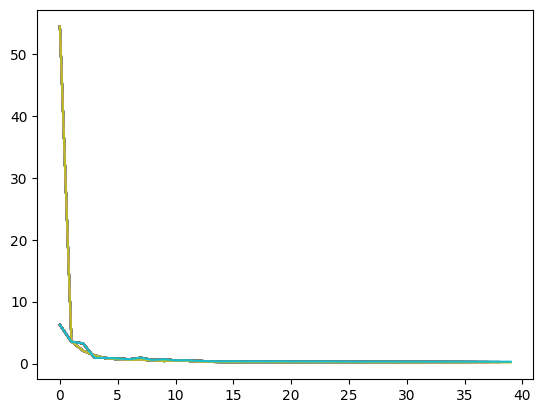

In [5]:
import sys
from matplotlib.pyplot import plot 

optimizer = scheduler.optimizer


epoch_losses = {"train": [], "val": []}
best_epoch_predictions = torch.tensor([])
best_epoch_loss = sys.float_info.max

best_epoch_actuals = torch.tensor([])
epoch_mads = {"train": [], "val": []}
num_epochs = 40
for epoch in range(num_epochs):
    print(f"Epoch {epoch}/{num_epochs - 1}")
    print("-" * 10)
    torch.autograd.set_detect_anomaly(True)
    # Each epoch has a training and validation phase
    for phase in ["train", "val"]:

        def on_batch_done(idx, outputs, loss, running_mad):
            if phase == "train":
                if not torch.isnan(loss):
                    loss.backward()
                    
                    threshold = 10
                    for p in model.parameters():
                        if p.grad is not None:
                            if p.grad.norm() > threshold:
                                torch.nn.utils.clip_grad_norm_(p, threshold)
                    optimizer.step()
                if torch.isnan(loss).any():
                    print(f"Nan loss: {torch.isnan(loss)}| Loss: {loss}")
            if idx % 10 == 0:
                tqdm.write(
                    "Epoch: [{}/{}], Batch: [{}/{}], batch loss: {:.6f}, epoch abs diff mean {:.6f}".format(
                        epoch,
                        num_epochs,
                        idx + 1,
                        len(dataloaders[phase]),
                        loss,
                        running_mad,
                    ),
                    end="\r",
                )

        if phase == "train":
            model.train()  # Set model to training mode
        else:
            model.eval()  # Set model to evaluate mode
        with torch.set_grad_enabled(phase == "train"):
            epoch_loss, epoch_mad = execute_epoch(
                model,
                criterion,
                dataloaders[phase],
                on_batch_done=on_batch_done,
                optimizer=optimizer,
            )
        epoch_mads[phase].append(epoch_mad)
        epoch_losses[phase].append(epoch_loss)

        if phase == "train":
            scheduler.step()

        print(f"{phase} Loss: {epoch_loss:.4f}")

        if phase == "val":
            if epoch_loss < best_epoch_loss:
                best_val_mad = epoch_mad
                best_epoch_loss = epoch_loss
    print()
    
    plot(range(len(epoch_losses["train"])),epoch_losses["train"])
    plot(range(len(epoch_losses["val"])),epoch_losses["val"])
print(f"Best val Acc: {best_epoch_loss:4f}")



if dataloaders["test"]:
    print("Executing validation on test set...")
    test_loss, test_mad = execute_epoch(
        model,
        criterion,
        dataloaders["test"],
        on_batch_done=on_batch_done,
        optimizer=optimizer,
    )
    print()


print({
        "model": model,
        "best_epoch_loss": best_epoch_loss,
        "test_loss": test_loss,
    })

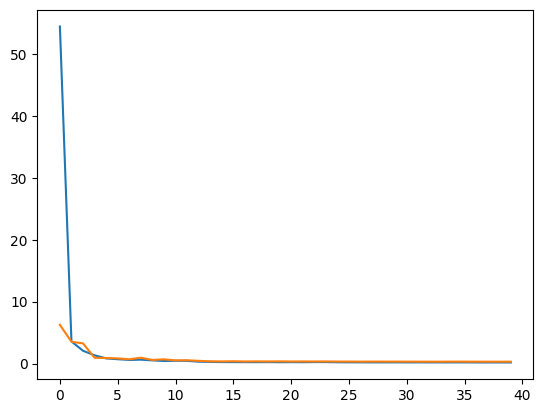

In [6]:
from matplotlib.pyplot import plot 

plot(range(len(epoch_losses["train"])),epoch_losses["train"])
plot(range(len(epoch_losses["val"])),epoch_losses["val"])

In [7]:
import matplotlib.pyplot as plt

def plotImg(a: torch.Tensor):
   
    plt.imshow(a.numpy(force=True))
    plt.colorbar()
    plt.savefig("vae.png")

def plotDiff(a: torch.Tensor, b: torch.Tensor):
    plotImg(torch.subtract(a,b).abs())

TypeError: Invalid shape (1, 1, 704, 1024) for image data

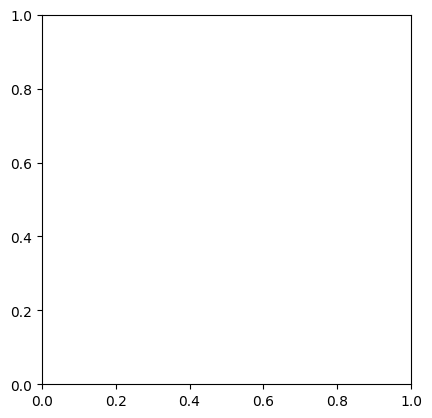